# CIFAR10 example with ResNet56

This example demonstrates the usage of `LRFinder` with a ResNet56 on the Cifar10 dataset.

In [18]:
import os

In [19]:
os.system('pip install torch-lr-finder')
from torch_lr_finder import LRFinder

In [20]:
import torch.nn as nn


__all__ = ["Cifar10ResNet", "resnet20", "resnet32", "resnet44", "resnet56", "resnet101"]


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Cifar10ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, ch_width=2):
        super(Cifar10ResNet, self).__init__()
        width = [16, 16 * ch_width, 16 * ch_width * ch_width]
        self.inplanes = 16
        self.conv1 = nn.Conv2d(
            3, width[0], kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(width[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, width[0], layers[0])
        self.layer2 = self._make_layer(block, width[1], layers[1], stride=2)
        self.layer3 = self._make_layer(block, width[2], layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(width[2] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet20(num_classes=10, ch_width=2):
    """Constructs a ResNet-20 model.
    """
    return Cifar10ResNet(
        BasicBlock, [3, 3, 3], num_classes=num_classes, ch_width=ch_width
    )


def resnet32(num_classes=10, ch_width=2):
    """Constructs a ResNet-32 model.
    """
    return Cifar10ResNet(
        BasicBlock, [5, 5, 5], num_classes=num_classes, ch_width=ch_width
    )


def resnet44(num_classes=10, ch_width=2):
    """Constructs a ResNet-44 model.
    """
    return Cifar10ResNet(
        BasicBlock, [7, 7, 7], num_classes=num_classes, ch_width=ch_width
    )


def resnet56(num_classes=10, ch_width=2):
    """Constructs a ResNet-56 model.
    """
    return Cifar10ResNet(
        BasicBlock, [9, 9, 9], num_classes=num_classes, ch_width=ch_width
    )


def resnet101(num_classes=10, ch_width=2):
    """Constructs a ResNet-101 model.
    """
    return Cifar10ResNet(
        BasicBlock, [18, 18, 18], num_classes=num_classes, ch_width=ch_width
    )

In [21]:
%matplotlib inline

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
# import cifar10_resnet as rc10
from torch_lr_finder import LRFinder


## Loading CIFAR10

In [22]:
cifar_pwd = "../data"
batch_size= 256

In [23]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root=cifar_pwd, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = CIFAR10(root=cifar_pwd, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [24]:
model = resnet56()

## Training loss (fastai)

This learning rate test range follows the same procedure used by fastai. The model is trained for `num_iter` iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to `end_lr`. The increase can be linear (`step_mode="linear"`) or exponential (`step_mode="exp"`); linear provides good results for small ranges while exponential is recommended for larger ranges.

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **training** loss.

LR suggestion: steepest gradient
Suggested LR: 1.00E-03


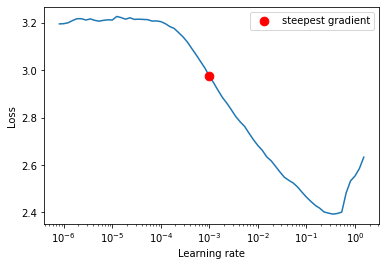

(<matplotlib.axes._subplots.AxesSubplot at 0x7f866671c150>,
 0.0009999999999999994)

In [26]:
lr_finder.plot()

In [28]:
lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]

0.3511191734215133

In [ ]:
# loss = [lr_finder.history['loss']
# lr = [lr_finder.history['loss']
# value = 0
# initial_value = 0
# first_record = True
# start
# starting
# for value in loss:
#   if first_record:
#     initial_value = value
#     first_record = False
#   else:
#     if value < initial_value:

#   if value > initial_value:
    


In [78]:
lr_finder.history['loss']

[3.1798477172851562,
 3.1784368991851806,
 3.1856140184402464,
 3.1866610739231107,
 3.190772682321071,
 3.1879642828279726,
 3.1952443781271866,
 3.193056085669649,
 3.1951687018230257,
 3.199441510056154,
 3.194943835073671,
 3.1958933882388103,
 3.1998566510129964,
 3.2093165214614614,
 3.216863219039511,
 3.2167235740940052,
 3.21130246544622,
 3.2158972232888687,
 3.209947635619146,
 3.2064902895628284,
 3.2100237000228886,
 3.212153537951889,
 3.211340525437229,
 3.2263833738907093,
 3.221509541538032,
 3.2148276420368136,
 3.2206797519660704,
 3.2139611764122917,
 3.214797748843966,
 3.2138289342663,
 3.212881285332068,
 3.2069027507934003,
 3.207413323760169,
 3.2045381681503162,
 3.1960455760918296,
 3.184205867477668,
 3.175880548106622,
 3.1585942535694853,
 3.14064235365804,
 3.1186596267679842,
 3.091128568609211,
 3.064442521057199,
 3.0362241500969596,
 3.00803218907496,
 2.974474625737087,
 2.9453485082617252,
 2.9133726425448363,
 2.883449638297691,
 2.8593209705650877

**the author advises the point at which the loss starts descending and the point at which the loss stops descending or becomes ragged for start_lr and end_lr** 

In [76]:
import pandas as pd 
# Calling DataFrame constructor on list
lr_finder_data_df = pd.DataFrame(list(zip(lr_finder.history['lr'], lr_finder.history['loss'])))
lr_finder_data_df.columns =['ls', 'loss']

In [77]:
lr_finder_data_df.head()

,ls,loss
0,1.000000e-07,3.179848
1,1.232847e-07,3.178437
2,1.519911e-07,3.185614
3,1.873817e-07,3.186661
4,2.310130e-07,3.190773


To restore the model and optimizer to their initial state use the `reset()` method.

In [ ]:
lr_finder.reset()

In [15]:
lr_finder.history['lr']

[]

ValueError: ignored

## Validation loss (Leslie N. Smith)

If a dataloader is passed to `LRFinder.range_test()` through the `val_loader` parameter the model is evaluated on that dataset after each iteration. The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. The disadvantage is that it takes significantly longer to run.

This version of the learning rate range test is described in [Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith](https://arxiv.org/abs/1506.01186).

In [11]:
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=100, num_iter=100, step_mode="exp")

RuntimeError: ignored

Note that the loss in the loss vs. learning rate plot is the **evaluation** loss.

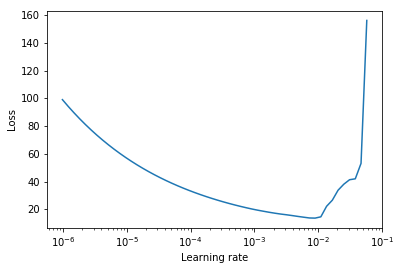

In [ ]:
lr_finder.plot(skip_end=0)

To restore the model and optimizer to their initial state use the `reset()` method.

In [ ]:
lr_finder.reset()